# 1. EDA

## 1.1 Load Datasets

In [185]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [171]:
# Import dataset
df_train = pd.read_csv("data/train.csv", index_col="PassengerId")
df_test = pd.read_csv("data/test.csv", index_col="PassengerId")
print("Train shape:", df_train.shape)
print("Test shape:", df_test.shape)
df_train.head()

Train shape: (891, 11)
Test shape: (418, 10)


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


- **Passenger Id**: the unique id of the row
- **Survived**: target variable
    - 1 = Survived
    - 0 = Not Survived
- **Pclass**: categorical feature describing passenger class
    - 1 = Upper Class
    - 2 = Middle Class
    - 3 = Lower Class
- **Name, Sex and Age** are self-explanatory
- **SibSp** is the total number of the passengers' siblings and spouse
- **Parch** is the total number of passengers' parents and children
- **Ticket** is the ticket number of the passenger
- **Fare** is the passenger fare
- **Cabin** is the cabin nuber ofthe passenger
- **Embarked** is the port of embarkation
    - C = Cherbourg
    - Q = Queenstown
    - S = Southampton

In [176]:
# Check info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Age       1309 non-null   float64
 1   Cabin     1309 non-null   object 
 2   Embarked  1309 non-null   object 
 3   Fare      1309 non-null   float64
 4   Name      1309 non-null   object 
 5   Parch     1309 non-null   int64  
 6   Pclass    1309 non-null   int64  
 7   Sex       1309 non-null   object 
 8   SibSp     1309 non-null   int64  
 9   Survived  891 non-null    float64
 10  Ticket    1309 non-null   object 
 11  Deck      1309 non-null   object 
dtypes: float64(3), int64(3), object(6)
memory usage: 122.8+ KB


We have some missing values we will deal with later in the notebook

In [173]:
# Check basic statistics
df.describe()

,Age,Fare,Parch,Pclass,SibSp,Survived
count,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,891.000000
mean,29.261398,33.276044,0.385027,2.294882,0.498854,0.383838
std,13.218275,51.743657,0.865560,0.837836,1.041658,0.486592
min,0.170000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,22.000000,7.895800,0.000000,2.000000,0.000000,0.000000
50%,26.000000,14.454200,0.000000,3.000000,0.000000,0.000000
75%,36.000000,31.275000,0.000000,3.000000,1.000000,1.000000
max,80.000000,512.329200,9.000000,3.000000,8.000000,1.000000


Sex mapping: {'female': 0, 'male': 1}
Embarked mapping: {'C': 0, 'Q': 1, 'S': 2}


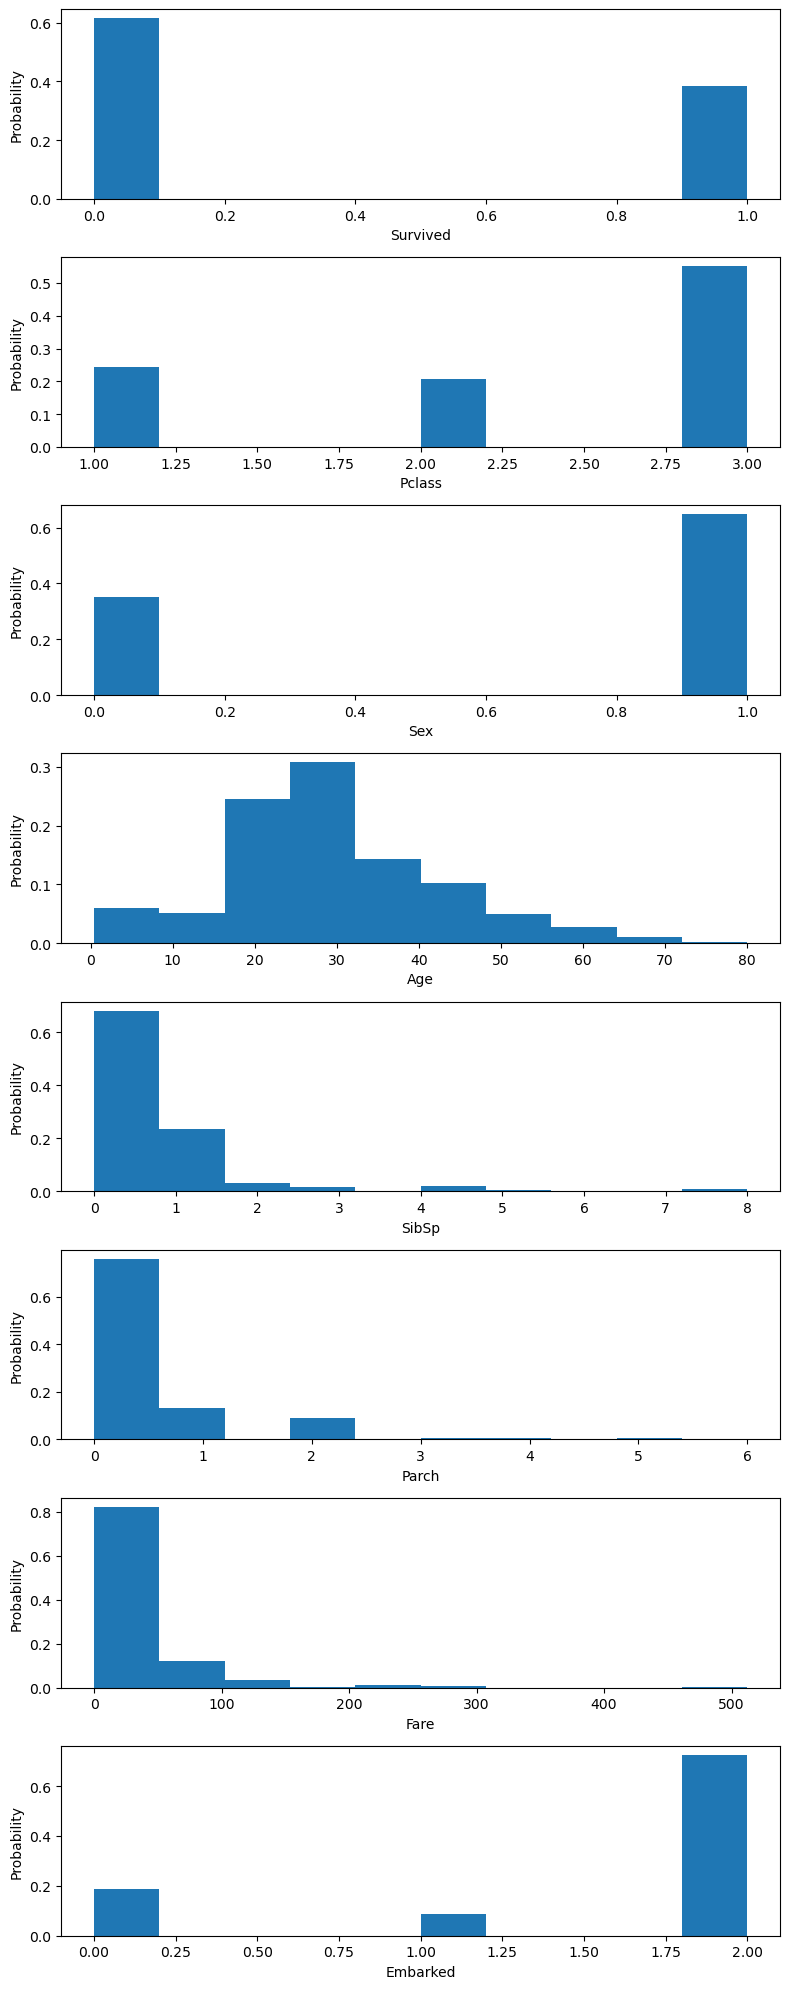

In [218]:
# Check distributions
cols = ["Survived", "Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]
fig, axes = plt.subplots(len(cols), 1, figsize=(8, 20))
axes = axes.flatten()
for i, c in enumerate(cols):
    ax = axes[i]
    if c in ["Sex", "Embarked"]:
        le = LabelEncoder()
        shape = df.dropna().shape[0]
        weights = np.ones(shape) / shape
        pd.Series(le.fit_transform(df[c])).plot.hist(rot=0, ax=ax, weights=weights)
        mapping = {cl: le.transform([cl])[0] for cl in le.classes_}
        print(f"{c} mapping:", mapping)
    else:
        shape = df.dropna().shape[0]
        weights = np.ones(shape) / shape
        df[c].plot.hist(rot=0, ax=ax, weights=weights)
    ax.set_ylabel("Probability")
    ax.set_xlabel(c)
plt.tight_layout()
plt.show()

Looking at the distributions of the features and the target, we can say that:
- 60% of the passengers did not survive
- Most of the passengers (about 55%) belong to Pclass 3
- Most of the passengers (about 60%) are male
- Most of the passengers are between 20 and 50 years old
- SibSp, Parch and Fare are skewed to the left
- Most of the passengers embarked from Southampton

Let's have a look at the correlation among the features and the target

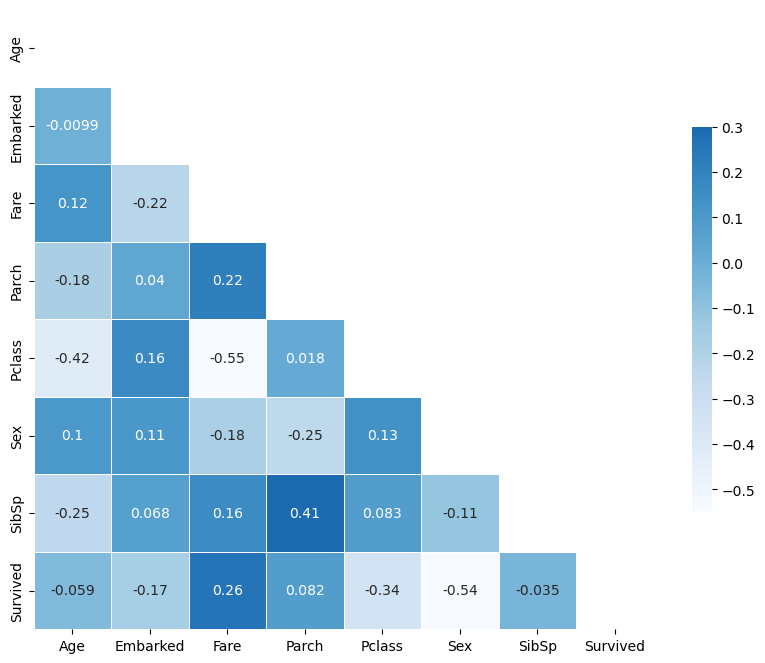

In [227]:
# Make copy of df
tmp = df.copy()

# Label encode Sex and embarked features
tmp["Sex"] = LabelEncoder().fit_transform(tmp["Sex"])
tmp["Embarked"] = LabelEncoder().fit_transform(tmp["Embarked"])

# Compute the correlation matrix
corr = tmp.corr(numeric_only=True)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(10, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, vmax=.3, center=0, cmap="Blues", annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
# Show
plt.show()

From the above heatmap, we can see that:
- Age anti-correlate with Pclass (passengers belonging to upper classes tend to be older)
- Embarked anti-correlate with Fare
- Fare anti-correlate with Pclass and correlate with Parch, SibSp and Survived (passengers from upper class pay more and are more likely to survive)
- Parch correlates with SibSp (if there are children, it is likely that there is also a spouse etc...)
- Pclass anti-correlate with Survived (passengers belonging to upper classes are more likely to survive)
- Sex anti-correlate with Survived (female passengers are more likely to survive)

## 1.2 Missing Data

In [93]:
# Let's print info abpout the datasets
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [94]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       332 non-null    float64
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      417 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 35.9+ KB


We see that there are missing values in *Age*, *Cabin* and *Embarked* columns in training set and *Age*, *Cabin* and *Fare* in test set. Let's concat train and test to study missing data. In this way we avoid filled data to overfit to train or test samples.

In [95]:
df = pd.concat([df_train, df_test], sort=True).reset_index(drop=True)
df.sample(3)

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket
199,24.0,NaN,S,13.0000,"Yrois, Miss. Henriette (""Mrs Harbeck"")",0,2,female,0,0.0,248747
878,NaN,NaN,S,7.8958,"Laleff, Mr. Kristo",0,3,male,0,0.0,349217
537,30.0,NaN,C,106.4250,"LeRoy, Miss. Bertha",0,1,female,0,1.0,PC 17761


### 1.2.1 Age

Let's check how Age is related to other features. We don't check the relation with the target because we cannot use it to reconstruct the missing values in the test set. We do not check *Name* and *Ticket* because of the huge number of distinct values. We do not check *Cabin* because of the huge number of missing values.  

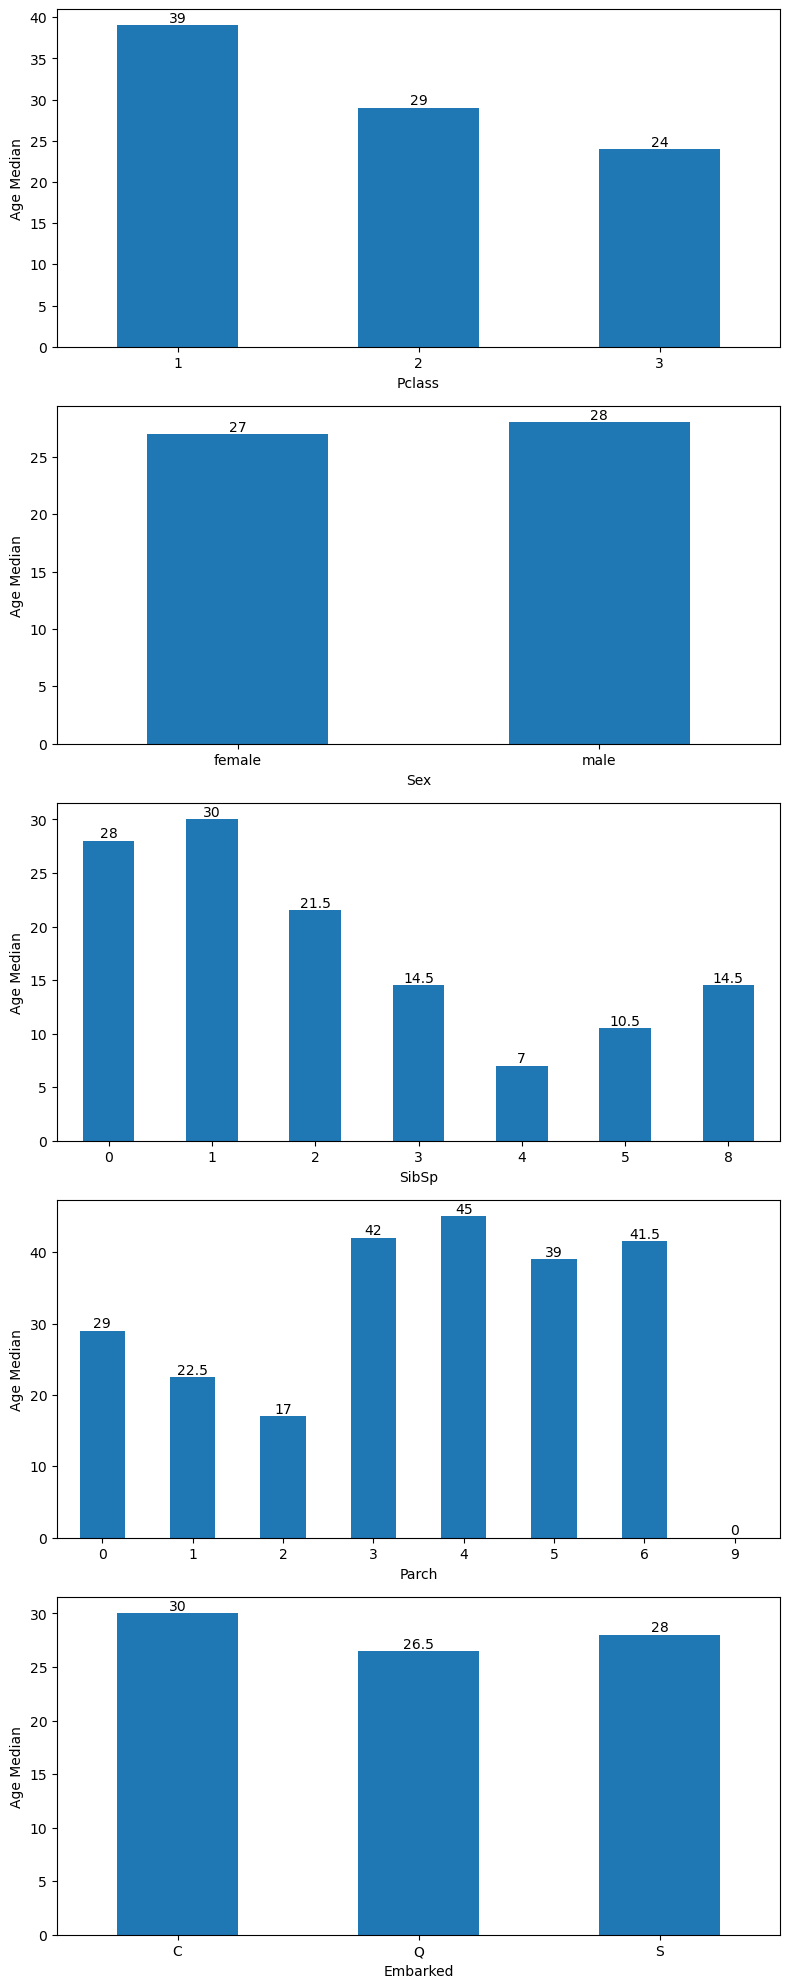

In [96]:
cols = ["Pclass", "Sex", "SibSp", "Parch", "Embarked"]
fig, axes = plt.subplots(len(cols), 1, figsize=(8, 20))
axes = axes.flatten()
for i, c in enumerate(cols):
    ax = axes[i]
    df.groupby(c)["Age"].median().plot.bar(rot=0, ax=ax)
    ax.set_ylabel("Age Median")
    ax.bar_label(ax.containers[0])
plt.tight_layout()
plt.show()

We see that we can use *Pclass* and *Sex* to reconstruct the missing data. Let's further investigate the relation between these two features and age.

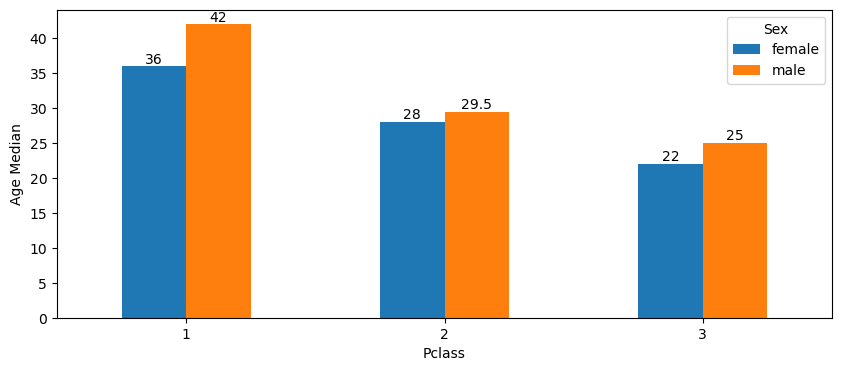

In [119]:
fig, ax = plt.subplots(figsize=(10, 4))
df.groupby(["Sex", "Pclass"])["Age"].median().unstack(level=0).plot.bar(rot=0, ax=ax)
ax.set_ylabel("Age Median")
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
plt.show()

Let's now impute the missing values

In [121]:
df["Age"] = df.groupby(['Sex', 'Pclass'], group_keys=False)['Age'].apply(lambda x: x.fillna(x.median()))

### 1.2.2 Embarked

In [122]:
df[df["Embarked"].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,1,female,0,1.0,113572
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,1,female,0,1.0,113572


We have just two missing values for *Embarked*. In principle, we can use the mode of *Embarked* for upper class female passengers to fill these values. However, it turns out that we can retrieve this information by googling the names of the passengers. Both of them embarked from Southampton, so we are going to fill these missing values with *S*.

In [124]:
df["Embarked"].fillna("S", inplace=True)

### 1.2.3 Fare

In [125]:
df[df["Fare"].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket
1043,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,3,male,0,NaN,3701


We can impute this value by assuming that the fare of the ticket is dependent by the class *Pclass* and the family size, i.e. *Parch* + *SibSp*

In [131]:
df["Fare"].fillna(df.groupby(["Pclass", "Parch", "SibSp"])["Fare"].median()[3][0][0], inplace=True)

### 1.2.4 Cabin

*Cabin* has a lot of missing values (almost 80% of the values), however it cannot be discarded because it is linked to the decks where passengers were located on the ship. It is reasonable therefore to assume that there's a link between this feature and the target and to further investigate it. In particular, we can create the feature *Deck* by discarding the numbers and keeping only the first letter in the *Cabin* feature. We will collect all the missing values under an assigned deck call *NA*.

In [139]:
df["Cabin"].fillna("NA", inplace=True)
df["Deck"] = df["Cabin"].apply(lambda x: x[0] if x != "NA" else x)

Let's check the relation between *Deck* and *Pclass* and *Deck* and *Survived*

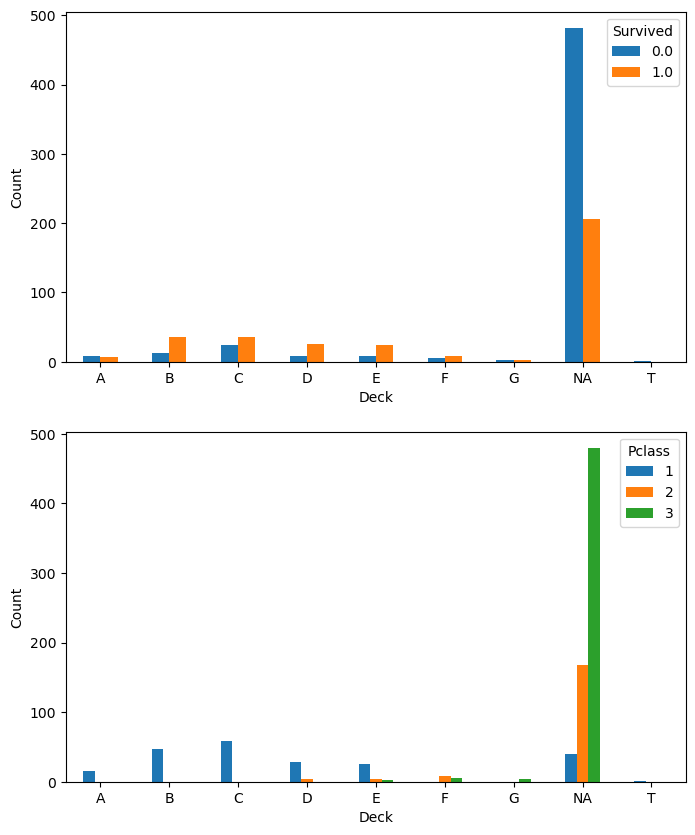

In [170]:
cols = ["Survived", "Pclass"]
fig, axes = plt.subplots(len(cols), 1, figsize=(8, 10))
axes = axes.flatten()
for i, c in enumerate(cols):
    ax = axes[i]
    df.groupby(["Deck", c])["Survived"].count().unstack(level=1).plot.bar(rot=0, ax=ax)
    ax.set_ylabel("Count")
plt.show()

We see that survival rate and passengers class differ considerably from deck to deck. More specifically, we see that cabins occupied by passengers with upper classes show an higher survival rate.

## References

- https://www.kaggle.com/competitions/titanic/overview
- https://www.kaggle.com/code/surenvayradyan/top-1-realscores-vayradyan-s-titanic
- https://www.kaggle.com/code/shivam6862/titanic-disaster-score-0-80382
- https://www.kaggle.com/code/andreynesterov/titanic-predictions